##### **Self notes**

In [1]:
# model loading and saving
# I want to load my .pkl file and use it to make predictions:
# 1. Load the model like this:


In [2]:
#1. So, we're not only going to use CNN because unlike RNN, CNN won't capture the essential temporal aspects.

#2. By combining CNNs for feature extraction from each frame and feeding those features into RNNs, we can create a model that understands both what’s
#3.  happening in each frame (objects, actions) and how those elements unfold over time (e.g., someone walking vs. running).

#4. CNN-RNN approach leads to more accurate video classification.

# Goal:
# Identify actions within videos by capturing spatial features from frames with a CNN and modeling temporal relationships between these features using an RNN.

### Libraries & data setup

In [2]:
!pip install -q imageio
!pip install -q opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install tensorflow
!pip install tensorflow_hub

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from typing import Counter
import pickle



# TensorFlow and TF-Hub modules.
from absl import logging

import tensorflow as tf
import tensorflow_hub as hub
# from tensorflow_docs.vis import embed
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.utils import to_categorical


logging.set_verbosity(logging.ERROR)

# Some modules to help with reading the UCF101 dataset.
import random
import re
import os
import tempfile
import ssl
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pickle

# Some modules to display an animation using imageio.
import imageio
from IPython import display

from urllib import request  # requires python3

from tensorflow.keras.applications import Xception
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.xception import preprocess_input, decode_predictions

In [3]:
print(tf.__version__)

2.16.1


#### Helper functions for the UCF101 dataset

In [4]:
# Helpers to fetch videos from UCF101 dataset
UCF_ROOT = "https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/"
_VIDEO_LIST = None
_CACHE_DIR = tempfile.mkdtemp()

unverified_context = ssl._create_unverified_context()

def list_ucf_videos(): # This function lists the videos available in the UCF101 dataset by parsing the HTML index of the dataset directory.
  global _VIDEO_LIST
  if not _VIDEO_LIST:
    index = request.urlopen(UCF_ROOT, context=unverified_context).read().decode("utf-8") # Fetch the HTML index of the UCF101 dataset directory.
    videos = re.findall("(v_[\w_]+\.avi)", index) # Parse the HTML index to find the video files.
    _VIDEO_LIST = sorted(set(videos)) # Remove duplicates and sort the list of video files.
  return list(_VIDEO_LIST)

def fetch_ucf_video(video): # This function fetches a specific video from the UCF101 dataset and caches it into the local filesystem to avoid repeated downloads.
  """Fetches a video and cache into local filesystem."""
  cache_path = os.path.join(_CACHE_DIR, video) # Define the cache path for the video.
  if not os.path.exists(cache_path):
    urlpath = request.urljoin(UCF_ROOT, video) # Construct the URL for the video.
    print("Fetching %s => %s" % (urlpath, cache_path)) # Print feedback about the video fetching process.
    data = request.urlopen(urlpath, context=unverified_context).read() # Fetch the video data.
    open(cache_path, "wb").write(data) # Cache the video data into the local filesystem.
  return cache_path

def crop_center_square(frame): # This function crops the center square of a frame to maintain the aspect ratio.
  y, x = frame.shape[0:2] # Get the dimensions of the frame.
  min_dim = min(y, x) # Calculate the minimum dimension of the frame.
  start_x = (x // 2) - (min_dim // 2) # Calculate the starting position for the crop.
  start_y = (y // 2) - (min_dim // 2) # Calculate the starting position for the crop.
  return frame[start_y:start_y+min_dim,start_x:start_x+min_dim] # Return the center square of the frame.

def load_video(path, max_frames, resize=(224, 224)): # This function loads a video file from the given path using OpenCV.
# It also resizes each frame to the specified dimensions and converts the color channels from BGR to RGB.
  cap = cv2.VideoCapture(path)
  frames = []
  try:
    while True:
      ret, frame = cap.read()
      if not ret:
        break
      frame = crop_center_square(frame) # Crop the center square of the frame.
      frame = cv2.resize(frame, resize) # Resize the frame to the specified dimensions.
      frame = frame[:, :, [2, 1, 0]] # BGR -> RGB # OpenCV reads the color channels in BGR format, but TensorFlow models expect RGB format.
      frames.append(frame) # Append the frame to the list of frames.

      if len(frames) == max_frames:
        break
  finally:
    cap.release()
  return np.array(frames) / 255.0


#### Get the kinetics-400 labels

In [5]:
# Get the kinetics-400 action labels from the GitHub repository.
KINETICS_URL = "https://raw.githubusercontent.com/deepmind/kinetics-i3d/master/data/label_map.txt"
with request.urlopen(KINETICS_URL) as obj:
  labels = [line.decode("utf-8").strip() for line in obj.readlines()]
print("Found %d labels." % len(labels))

Found 400 labels.


#### Using the UCF101 dataset

In [6]:
# Get the list of videos in the dataset.
ucf_videos = list_ucf_videos()

categories = {} # To store videos categorized by their actions ''''' Might need it later
video_paths = []
labels = []

for video in ucf_videos:
  category = video[2:-12]
  if category not in categories:
    categories[category] = []
  categories[category].append(video)
print("Found %d videos in %d categories." % (len(ucf_videos), len(categories)))

max_total_videos = 300
selected_categories = ['Basketball','HammerThrow', 'Mixing']
total_videos_added = 0

for category, sequences in categories.items():
    if category in selected_categories:
        videos_to_add = min(len(sequences), max_total_videos - total_videos_added) # So that the total number of videos will be 300
        summary = ", ".join(sequences[:2])
        print("%-20s %4d videos (%s, ...)" % (category, len(sequences), summary))
        for video in sequences[:videos_to_add]:
          video_path = fetch_ucf_video(video)
          video_paths.append(video_path)
          labels.append(video)
          total_videos_added += 1

Found 13320 videos in 101 categories.
Basketball            134 videos (v_Basketball_g01_c01.avi, v_Basketball_g01_c02.avi, ...)
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Basketball_g01_c01.avi => C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\v_Basketball_g01_c01.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Basketball_g01_c02.avi => C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\v_Basketball_g01_c02.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Basketball_g01_c03.avi => C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\v_Basketball_g01_c03.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Basketball_g01_c04.avi => C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\v_Basketball_g01_c04.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Basketball_g01_c05.avi => C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\v_Basketball_g01_c05.avi
Fetching https://www.crcv.ucf.edu/THUMOS14/UCF101/UCF101/v_Basketball_g01_c06.avi => C:\Use

### Creating a dataframe with two columns, one for videos paths and one for the labels

In [7]:
df = pd.DataFrame({"video_paths": video_paths, "labels": labels})

# saving df to csv
df.to_csv('videos_paths2.csv', index=False)
df.head(20)

,video_paths,labels
0,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c01.avi
1,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c02.avi
2,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c03.avi
3,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c04.avi
4,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c05.avi
5,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c06.avi
6,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g01_c07.avi
7,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g02_c01.avi
8,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g02_c02.avi
9,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,v_Basketball_g02_c03.avi


##### To save time of running the video fetching cell code

In [9]:
# df = pd.read_csv('videos_paths2.csv')

### Correctly labeling the paths 

In [8]:
df.loc[df['labels'].str.contains('Basketball', case=False), 'labels'] = 'Basketball'
df.loc[df['labels'].str.contains('HammerThrow', case=False), 'labels'] = 'HammerThrow'
df.loc[df['labels'].str.contains('Mixing', case=False), 'labels'] = 'Mixing'

df['labels'].value_counts()

df.head()

,video_paths,labels
0,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
1,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
2,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
3,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
4,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball


In [9]:
replace_words = ['Basketball', 'HammerThrow', 'Mixing'] # Defining the action labels to extract from the video filenames.

labels = [word for label in labels for word in replace_words if word.lower() in label.lower()] # Extracting the action label from the video filename.

value_counts = Counter(labels) # Counting the occurrences of each action label in the dataset.

print(value_counts)

Counter({'HammerThrow': 150, 'Basketball': 134, 'Mixing': 16})


### Splitting the dataset into training, validation, and testing sets

In [10]:
# Splitting the dataset into train and test sets
train_videos, test_videos, train_labels, test_labels = train_test_split(
    video_paths, labels, test_size=0.2, random_state=42)

# Further splitting the train set into train and validation sets
train_videos, val_videos, train_labels, val_labels = train_test_split(
    train_videos, train_labels, test_size=0.1, random_state=42)

# Creating DataFrames for train, validation, and test sets
train_df = pd.DataFrame({"video_paths": train_videos, "labels": train_labels})
val_df = pd.DataFrame({"video_paths": val_videos, "labels": val_labels})
test_df = pd.DataFrame({"video_paths": test_videos, "labels": test_labels})

# Print the sizes of the datasets
print("Train set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

Train set size: 216
Validation set size: 24
Test set size: 60


In [11]:
train_df.head()

,video_paths,labels
0,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
1,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
2,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
3,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball
4,C:\Users\ahmed\AppData\Local\Temp\tmphe0n0j2y\...,Basketball


In [12]:
train_df.shape

(216, 2)

### We chose the Xception CNN architecture as it offers several advantages over Inception, including improved computational efficiency due to its use of depthwise separable convolutions, which reduces the number of parameters and operations required. This efficiency makes Xception more suitable for our current task.

## Extracting features for training data

In [ ]:
base_model = Xception(weights='imagenet', include_top=False) # Load the Xception model pre-trained on ImageNet without the top layer.

extracted_features = []
for _, row in train_df.iterrows(): # Iterate over the rows of the train set DataFrame.
    frames_of_vid = load_video(row['video_paths'], max_frames=45)

    features = []
    for frame in frames_of_vid:
        x = np.expand_dims(frame, axis=0) # Expand the dimensions of the frame to match the input shape of the Xception model.
        x = preprocess_input(x) 
        frame_features = base_model.predict(x) 
        features.append(frame_features)

    extracted_features.append(np.array(features))

extracted_features = np.array(extracted_features)

# Savnig the extracted features to a file
with open('train_extracted_features.pkl', 'wb') as f: # Opening a file in write-binary mode.
    pickle.dump(extracted_features, f) # Saving the extracted features to the file.

print("Extracted features saved to extracted_features.pkl")


Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 21ms/step


## Extracting Features for Validation set

In [ ]:
validation_extracted_features = []
for _, row in val_df.iterrows():  # Assuming train_df is a pandas DataFrame
    frames_of_vid = load_video(row['video_paths'], max_frames=45)  # Assuming 'video_paths' is a column in train_df

    features = []
    for frame in frames_of_vid:
        x = np.expand_dims(frame, axis=0)
        x = preprocess_input(x)
        frame_features = base_model.predict(x)
        features.append(frame_features)

    validation_extracted_features.append(np.array(features))

# Save extracted features to a file
with open('validation_extracted_features.pkl', 'wb') as f:
    pickle.dump(validation_extracted_features, f)

print("Extracted features saved to extracted_features.pkl")

## Extracting Features for test set

In [ ]:
test_extracted_features = []
for _, row in test_df.iterrows():  # Assuming train_df is a pandas DataFrame
    frames_of_vid = load_video(row['video_paths'], max_frames = 45)  # Assuming 'video_paths' is a column in train_df

    features = []
    for frame in frames_of_vid:
        x = np.expand_dims(frame, axis=0)
        x = preprocess_input(x)
        frame_features = base_model.predict(x)
        features.append(frame_features)

    test_extracted_features.append(np.array(features))

print(test_extracted_features.length)

# Save extracted features to a file
with open('test_extracted_features.pkl', 'wb') as f:
    pickle.dump(test_extracted_features, f)

print("Extracted features saved to extracted_features.pkl")

### Loading extracted data

In [13]:
train_extracted_features = pickle.load(open('train_extracted_features.pkl', 'rb'))
validation_extracted_features = pickle.load(open('validation_extracted_features.pkl', 'rb'))
test_extracted_features = pickle.load(open('test_extracted_features.pkl', 'rb'))

validation_extracted_features = np.array(validation_extracted_features)
test_extracted_features = np.array(test_extracted_features)

print("Train features shape:", train_extracted_features.shape)
print("Validation features shape:", validation_extracted_features.shape)
print("Test features shape:", test_extracted_features.shape)

# 216 is number of vids
# 45 is the number of frames
# 7 is the height of the feature map
# 7 is the width of the feature map
# 2048 is the number of channels in the feature map

# 1 is a useless dimension

Train features shape: (216, 45, 1, 7, 7, 2048)
Validation features shape: (24, 45, 1, 7, 7, 2048)
Test features shape: (60, 45, 1, 7, 7, 2048)


## Reshaping extracted features to get rid of unwanted dimension

In [14]:
train_extracted_features = np.squeeze(train_extracted_features, axis=2)
print("Train features shape:", train_extracted_features.shape)
validation_extracted_features = np.squeeze(validation_extracted_features, axis=2)
print("Validation features shape:", validation_extracted_features.shape)
test_extracted_features = np.squeeze(test_extracted_features, axis=2)
print("Test features shape:", test_extracted_features.shape)

Train features shape: (216, 45, 7, 7, 2048)
Validation features shape: (24, 45, 7, 7, 2048)
Test features shape: (60, 45, 7, 7, 2048)


### label encoding our labels

In [15]:
label_encoder = LabelEncoder() # Initialize a label encoder to convert the action labels into numerical format.
train_df['labels'] = label_encoder.fit_transform(train_df['labels'])
val_df['labels'] = label_encoder.transform(val_df['labels'])
test_df['labels'] = label_encoder.transform(test_df['labels'])



### Reshaping features to fit into RNN

In [16]:
train_reshaped_features = train_extracted_features.reshape(216, 45, 7*7*2048)
validation_reshaped_features = validation_extracted_features.reshape(24, 45, 7*7*2048)
test_reshaped_features = test_extracted_features.reshape(60, 45, 7*7*2048)


## Implementing an RNN  GRU sequence model to capture temporal relationships between the extracted frame features. 

In [17]:
# Define the RNN model architecture
model = tf.keras.Sequential([
                                                                        
    tf.keras.layers.GRU(256, return_sequences=True),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.GRU(128),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(3, activation='softmax')
])
    # Add a dropout layer to prevent overfitting
    # Add a dense (fully connected) layer with 3 units (one for each class)
    # and a softmax activation function to convert output to probability distribution.

# Compile the model
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
            metrics=['accuracy']
)





### Combining features: Directly feeding the features into the first layer as it needs less computational power 

In [18]:
model.fit(train_reshaped_features, train_df['labels'].values, epochs=10, validation_data=(validation_reshaped_features, val_df['labels'].values))

Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 118s 14s/step - accuracy: 0.4282 - loss: 1.2723 - val_accuracy: 0.3750 - val_loss: 1.7343
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 119s 14s/step - accuracy: 0.4933 - loss: 1.1305 - val_accuracy: 0.4583 - val_loss: 1.1971
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 141s 17s/step - accuracy: 0.5071 - loss: 1.0879 - val_accuracy: 0.4167 - val_loss: 1.1731
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 315s 33s/step - accuracy: 0.5533 - loss: 0.9095 - val_accuracy: 0.3750 - val_loss: 1.3693
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 313s 36s/step - accuracy: 0.5273 - loss: 0.9728 - val_accuracy: 0.6250 - val_loss: 1.1114
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 398s 49s/step - accuracy: 0.5862 - loss: 0.9309 - val_accuracy: 0.5000 - val_loss: 1.1018
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 380s 46s/step - accuracy: 0.5870 - loss: 0.8369 - val_accuracy: 0.6667 - val_loss: 1.0983
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 211s 17s/step - accuracy: 0.6296 - loss: 0.8659 - val_accuracy: 0.5833 - val_loss:

## Dumping our model into pickl file

In [19]:
with open('model2.pkl', 'wb') as model_file:
    pickle.dump(model, model_file)

## Testing our model

In [20]:
model.evaluate(test_reshaped_features, test_df['labels'].values)

2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.7069 - loss: 0.6790


[0.6687924861907959, 0.7166666388511658]

## Evaluation metrics

In [21]:
# Now i'll evaluate the model’s performance on the testing set using metrics like accuracy, precision, recall,and F1-score:

predictions = model.predict(test_reshaped_features)
predictions = np.argmax(predictions, axis=1)

print(classification_report(test_df['labels'].values, predictions, target_names=label_encoder.classes_))

2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 3s/step
              precision    recall  f1-score   support

  Basketball       0.63      0.89      0.74        27
 HammerThrow       0.86      0.66      0.75        29
      Mixing       0.00      0.00      0.00         4

    accuracy                           0.72        60
   macro avg       0.50      0.51      0.49        60
weighted avg       0.70      0.72      0.69        60



c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\ahmed\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

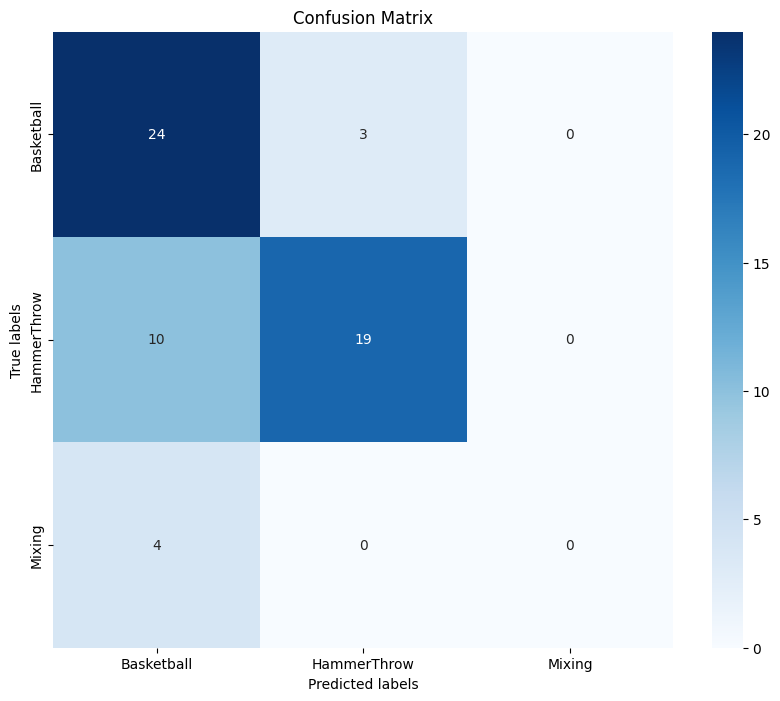

In [22]:
# confusion matrix to visualize the model’s classification performance across different action classes

# predictions = model.predict(test_reshaped_features)
# predicted_labels = np.argmax(predictions, axis=1)

cm = confusion_matrix(test_df['labels'].values, predictions)
plt.figure(figsize=(10, 8))

sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()